In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('Dataset\doge_dataset_day_ohlcvm.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Features and target
X = df[['open', 'high', 'low', 'volume_DOGE', 'market_cap', 'volume']]  # You can add more features if available
y = df['close']  # Target variable: closing price

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.0000
R² Score: 0.9962


## Correlation Matrix

In [3]:
print(df[['open', 'close', 'high', 'low', 'volume_DOGE', 'market_cap', 'volume']].corr())

                 open     close      high       low  volume_DOGE  market_cap  \
open         1.000000  0.995383  0.996608  0.996618     0.068783    0.748095   
close        0.995383  1.000000  0.998233  0.996842     0.079557    0.748373   
high         0.996608  0.998233  1.000000  0.994104     0.088358    0.740723   
low          0.996618  0.996842  0.994104  1.000000     0.060686    0.757410   
volume_DOGE  0.068783  0.079557  0.088358  0.060686     1.000000    0.066979   
market_cap   0.748095  0.748373  0.740723  0.757410     0.066979    1.000000   
volume       0.724094  0.727230  0.731679  0.719526     0.219756    0.531926   

               volume  
open         0.724094  
close        0.727230  
high         0.731679  
low          0.719526  
volume_DOGE  0.219756  
market_cap   0.531926  
volume       1.000000  


From the correlation matrix, we can see that market cap and price is correlated. Now there are two options:
- Building a time aware model: Model depend on the past data instead of the derived current values.
- Remove market cap from the features
I will focus more one first option as it could be more realistic

# Building a time-aware model

## Using lag 1

In [5]:
# Shifting features one day back to create lag features and time series analysis
df['market_cap_lag1'] = df['market_cap'].shift(1)
df['volume_lag1'] = df['volume'].shift(1)
df['volume_DOGE_lag1'] = df['volume_DOGE'].shift(1)
df['open_lag1'] = df['open'].shift(1)
df['high_lag1'] = df['high'].shift(1)
df['low_lag1'] = df['low'].shift(1)
df.dropna(inplace=True)

X = df[['market_cap_lag1', 'volume_lag1', 'volume_DOGE_lag1', 'open_lag1', 'high_lag1', 'low_lag1']]
y = df['close']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.0000
R² Score: 0.9983


We can see that $MSE$ and $R^2$ error showing good result for both the cases in above. Another possible reason to get so accurate result is testing and splitting in random manner. Lets do it in chornological manner

## Splitting the data in chronological manner 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2929, number of used features: 6
[LightGBM] [Info] Start training from score 0.027435
Linear Regression - MSE: 0.000101, R²: 0.9842
Random Forest - MSE: 0.000813, R²: 0.8733
XGBoost - MSE: 0.001726, R²: 0.7311
LightGBM - MSE: 0.000670, R²: 0.8956


C:\Users\miraz\AppData\Local\Temp\ipykernel_19496\1123084211.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\miraz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


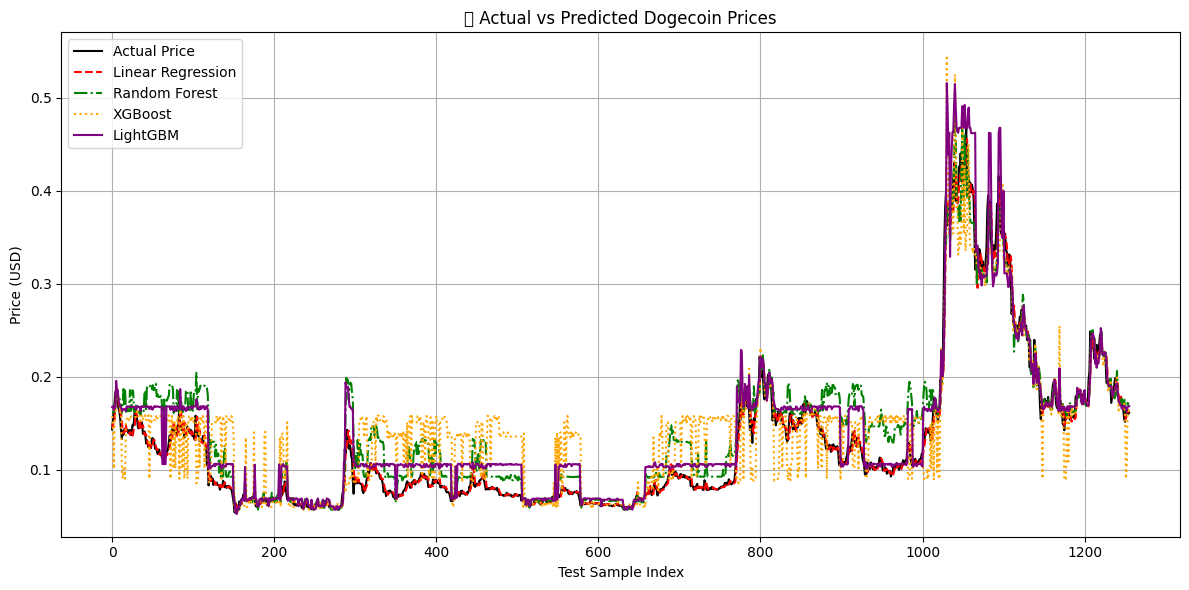

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Step 1: Load & Sort Data ---
df = pd.read_csv('Dataset/doge_dataset_day_ohlcvm.csv', parse_dates=['date'])
df = df.sort_values('date')
df.dropna(inplace=True)

# --- Step 2: Create Lag Features ---
df['market_cap_lag1'] = df['market_cap'].shift(1)
df['volume_lag1'] = df['volume'].shift(1)
df['volume_DOGE_lag1'] = df['volume_DOGE'].shift(1)
df['open_lag1'] = df['open'].shift(1)
df['high_lag1'] = df['high'].shift(1)
df['low_lag1'] = df['low'].shift(1)
df.dropna(inplace=True)

# --- Step 3: Define Features and Target ---
features = ['market_cap_lag1', 'volume_lag1', 'volume_DOGE_lag1', 
            'open_lag1', 'high_lag1', 'low_lag1']
target = 'close'

X = df[features]
y = df[target]

# Chronological Train-Test Split (70/30)
train_size = int(len(df) * 0.7)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# --- Step 4: Train Models ---

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_linear = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_random = rf_model.predict(X_test)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# LightGBM
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# --- Step 5: Evaluation ---
models = {
    "Linear Regression": y_pred_linear,
    "Random Forest": y_pred_random,
    "XGBoost": y_pred_xgb,
    "LightGBM": y_pred_lgb
}

for name, preds in models.items():
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} - MSE: {mse:.6f}, R²: {r2:.4f}")

# --- Step 6: Plotting ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Price', color='black')

plt.plot(y_pred_linear, label='Linear Regression', linestyle='--', color='red')
plt.plot(y_pred_random, label='Random Forest', linestyle='-.', color='green')
plt.plot(y_pred_xgb, label='XGBoost', linestyle=':', color='orange')
plt.plot(y_pred_lgb, label='LightGBM', linestyle='-', color='purple')

plt.title('📈 Actual vs Predicted Dogecoin Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Tommorrows price

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load & Sort Data
df = pd.read_csv('Dataset/doge_dataset_day_ohlcvm.csv', parse_dates=['date'])
df = df.sort_values('date')

# Step 2: Create Lag Feature for Prediction
last = df.iloc[-1]
X_tomorrow = pd.DataFrame([[
    last['market_cap'], 
    last['volume'], 
    last['volume_DOGE'], 
    last['open'], 
    last['high'], 
    last['low']
]], columns=[
    'market_cap_lag1', 'volume_lag1', 'volume_DOGE_lag1', 
    'open_lag1', 'high_lag1', 'low_lag1'
])

# Step 3: Build Lagged Dataset
df['market_cap_lag1'] = df['market_cap'].shift(1)
df['volume_lag1'] = df['volume'].shift(1)
df['volume_DOGE_lag1'] = df['volume_DOGE'].shift(1)
df['open_lag1'] = df['open'].shift(1)
df['high_lag1'] = df['high'].shift(1)
df['low_lag1'] = df['low'].shift(1)
df.dropna(inplace=True)

# Step 4: Split Data
features = ['market_cap_lag1', 'volume_lag1', 'volume_DOGE_lag1', 
            'open_lag1', 'high_lag1', 'low_lag1']
X = df[features]
y = df['close']
train_size = int(len(df) * 0.7)
X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]

# Step 5: Train All Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
}

# Step 6: Fit and Predict for Today
print(f"📅 Based on yesterday’s data ({last['date'].date()}),")
for name, model in models.items():
    model.fit(X_train, y_train)
    predicted_price = model.predict(X_tomorrow)[0]
    print(f"🔹 {name} predicted Dogecoin price: ${predicted_price:.6f}")


📅 Based on yesterday’s data (2025-06-27),
🔹 Linear Regression predicted Dogecoin price: $0.157493
🔹 Random Forest predicted Dogecoin price: $0.162845
🔹 XGBoost predicted Dogecoin price: $0.164886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2929, number of used features: 6
[LightGBM] [Info] Start training from score 0.027435
🔹 LightGBM predicted Dogecoin price: $0.167169
